In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf as erf
from scipy.integrate import quad as quad


In [151]:
Nr = lambda v , Dg , H0, R0, Ds: (2*np.pi*v) / Dg + H0*np.sqrt( ( 2*np.pi*R0*v)/Ds)

In [25]:
Lg = lambda Ds, R0, v, t, Dg, H:(4*Ds) / (Dg*(R0+v*t))


In [271]:
allee = lambda n,r ,B,K: r*(1-n/K)*(n/B-1)

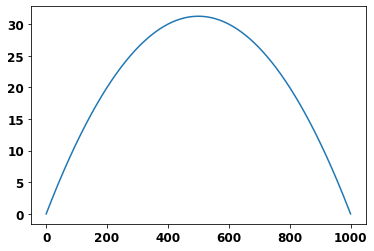

In [279]:
plt.plot([allee(n,.01,.08 ,1000) for n in np.linspace(0,1000,1001)])

In [55]:
Ht_1 = lambda sig, H0,t:H0 - H0*np.sqrt(1 +sig*t) / np.sqrt(2*np.pi*sig) * (np.pi/2   -np.arcsin(1 / np.sqrt(1 + sig*t) ) )
Ht_2 = lambda sig, H0,t: H0*np.sqrt(( np.pi*(1+sig*t))/ 8*sig ) * np.exp(( 1+sig*t ) / 8*sig ) 
Ht_3 = lambda sig, H0,t: erf(np.sqrt( (1+sig*t)/ (8*sig ) )) - erf(1/np.sqrt(8*sig))
Ht_4 = lambda sig, H0,t: H0*np.sqrt(( np.pi*(1+sig*t))/ 8*sig ) * (np.exp(t/8) - 1 ) 
Ht_int =lambda x: np.exp(-x/8)*np.arcsin(1 / np.sqrt(1 + sig*x)) 
Ht_5 = lambda sig, H0, t: H0*np.sqrt( (1+sig*t)/ (128*sig*np.pi) ) * np.exp(t/8) *quad(Ht_int, 0, t)[0]



In [56]:
Ht0 = lambda sig, H0,t: Ht_1(sig,H0,t) +Ht_2(sig,H0,t)*Ht_3(sig,H0,t) - Ht_4(sig,H0,t) + Ht_5(sig,H0,t)

In [114]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from scipy import integrate
from matplotlib.colorbar import Colorbar

def profile_decay(r, migr, B):
    if B <= 2.0:
        lm = np.sqrt(2.*r/migr)
    else:
        lm = np.sqrt(r*B/migr)
    return lm

def profile(gf, migr, fstr, x):
    D = migr/2.
    if fstr > -0.5:
        prof = 1./(1. + np.exp(np.sqrt(gf/(2.*D))*x))
    else:
        prof = 1./(1. + np.exp(np.sqrt(gf*abs(fstr)/D)*x))
    return prof

def velocity(g, m, f):
    D = m/2.
    if f >= -0.5:
        v = np.sqrt(D*g/2.)*(1 - 2.*f)
    else:
        v = 2.*np.sqrt(D*g*abs(f))
    return v

def velocity_Fisher(g, m, f):
    D = m/2.
    if f <= 0.0:
        v_F = 2.*np.sqrt(D*g*abs(f))
    else:
        v_F = 0.
    return v_F

def v_coop(r, m, B):
    D = m/2.
    if B > 2.:
        v = np.sqrt(D*r*B/2.)*(1 + 2./B)
    else:
        v = 2.*np.sqrt(D*r)
    return v

def vF_coop(r, m, B):
    D = m/2.
    vF = 2.*np.sqrt(D*r)
    return vF

def growth(g, f, x):
    return g*(1 - x)*(x - f)

def fixation_const(gf, migr, fstr, x_min, x_max, dx):
    x_arr = np.arange(x_min, x_max, dx)
    c_arr = profile(gf, migr, fstr, x_arr)
    v = velocity(gf, migr, fstr)
    D = migr/2.

    prelim_prob = c_arr**2*np.exp(v*x_arr/D)
    const = integrate.simps(prelim_prob, x_arr)
    return const

def fixation_probability(gf, migr, fstr, x_min, x_max, dx, x):
    c = profile(gf, migr, fstr, x)
    v = velocity(gf, migr, fstr)
    D = migr/2.
    const = fixation_const(gf, migr, fstr, x_min, x_max, dx)
    prob = c**2*np.exp(v*x/D)/const
    return prob

def ancestral_probability(gf, migr, fstr, x_min, x_max, dx, x):
    c = profile(gf, migr, fstr, x)
    v = velocity(gf, migr, fstr)
    D = migr/2.
    const = fixation_const(gf, migr, fstr, x_min, x_max, dx)
    prob = c**3*np.exp(2*v*x/D)/(const**2)
    return prob

def meanfield_cutoff(gf, migr, fstr, N):
    D = migr/2.
    if fstr > -0.5:
        k = np.sqrt(gf/(2.*D))
    else:
        k = np.sqrt(gf*abs(fstr)/D)
    return np.log(N)/k

def fluctuations_cutoff(gf, migr, fstr, N):
    D = migr/2.
    if fstr > -0.5:
        q = -2.*fstr*np.sqrt(gf/(2.*D))
    else:
        q = np.sqrt(gf*abs(fstr)/D)
    return np.log(N)/q

def Lambda_theory_cooperative(B, N):
    return np.sqrt(0.01*B/0.25)*4*np.pi*np.tan(2*np.pi/B)/(B+4)/N

def Lambda_theory_Allee(fstr, N, x_min, x_max, dx,gf,migr):
    x_arr = np.arange(x_min, x_max, dx)
    c_arr = profile(gf, migr, fstr, x_arr)
    v = velocity(gf, migr, fstr)
    D = migr/2.

    const = fixation_const(gf, migr, fstr, x_min, x_max, dx)
    function = c_arr**3*np.exp(2*v*x_arr/D)/(const**2)

    Lambda = (1./N)*integrate.simps(function, x_arr)
    return Lambda

def Df_theory(r, m, B, N):
    D = m/2.
    x = 2./B
    lm = profile_decay(r, 2*D, B)

    const = 3/(20*np.pi*N*lm)
    trig = np.tan(2*np.pi/B)
    algebr = (B*(B+4.)*(3*B+4.))/((B+1.)*(B+2.))
    return const*trig*algebr

def det_metastable(a):
    return 2*np.sqrt(a**2 + 4*(1. - a))/(a + np.sqrt(a**2 + 4*(1. - a)))

def meanfield_exponent(f):
    v = velocity(0.01, 0.25, f)
    vF = velocity_Fisher(0.01, 0.25, f)
    v_arr = v/vF
    return v_arr, -2 - 4*f

def fluctuations_exponent(f):
    v = velocity(0.01, 0.25, f)
    vF = velocity_Fisher(0.01, 0.25, f)
    v_arr = v/vF
    return v_arr, (1 + 2*f)/(2.*f)


In [219]:
m = .1
a =  1
tau = 1
r0=.01
f  =-.4
Ne =1/Lambda_theory_Allee(f, 1000 , -100, 40, .01,r0,m)

Ds = m*a**2/2
R0 = .4
Dg= a / ( Ne*tau)
sig = v*Ds/(R0*Dg**2)


In [250]:
Ht0(sig,H0,t)
sig

0.9949480573799571

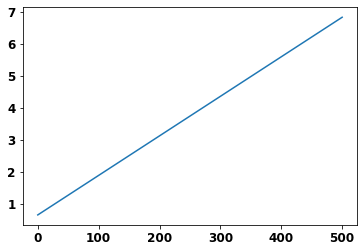

In [247]:

plt.plot( [  (2*np.pi)/Lg (Ds,R0,v, t,Dg, Ht0(sig,H0,t) ) for t in np.linspace(0,100,501)])

In [230]:
sig = v*Ds/(R0*Dg**2)

In [245]:
R0

0.3

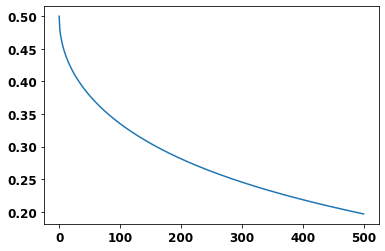

In [232]:

plt.plot([Ht0(sig,H0,t) for t in  np.linspace(0,5,501)])

5.092320960942035
5.132034201249407
5.334817059758884
5.9676768871501
7.681420194626565
11.873497306143033
20.92044648905422
37.409908326284246
61.97942530244645
92.07824001760602
123.81879422239828
154.4118542306209
182.66328035868472
208.33176922124989
231.54452785276195
252.51989440518312
271.47205623487633
288.58723238397414
304.0220910995153
317.9075488944236


<ipython-input-335-5e14f5012086>:17: RuntimeWarning: divide by zero encountered in double_scalars
  plt.scatter(-1/f,Nr(v,Dg,H0,20,Ds) , c='k')


Text(0.5, 0, 'B')

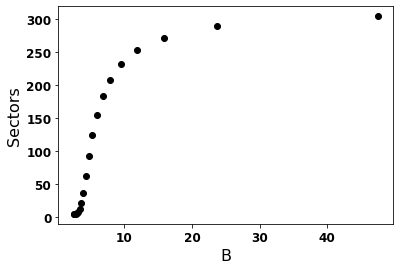

In [335]:
fspace = np.linspace(-.4,0,20)
m = .05
a =  1
tau = 1
r0=.01
K = 1000
H0=.5
for f in fspace:
    v = velocity(r0,m,f)
    Ne =1/Lambda_theory_Allee(f, K , -100, 40, .01,r0,m)

    Ds = m*a**2/2
    Dg= a / ( Ne*tau)
    sig = v*Ds/(R0*Dg**2)
    print(Nr(v,Dg,H0,20,Ds))
    
    plt.scatter(-1/f,Nr(v,Dg,H0,20,Ds) , c='k')
    
#plt.yscale('log')
plt.ylabel('Sectors',fontsize=16)
plt.xlabel('B',fontsize=16)

5.092320960942035
5.132034201249407
5.334817059758884
5.9676768871501
7.681420194626565
11.873497306143033
20.92044648905422
37.409908326284246
61.97942530244645
92.07824001760602
123.81879422239828
154.4118542306209
182.66328035868472
208.33176922124989
231.54452785276195
252.51989440518312
271.47205623487633
288.58723238397414
304.0220910995153
317.9075488944236


<ipython-input-338-b685bc8c505a>:17: RuntimeWarning: divide by zero encountered in double_scalars
  plt.scatter(-1/f,1/Dg , c='k')


Text(0.5, 0, 'B')

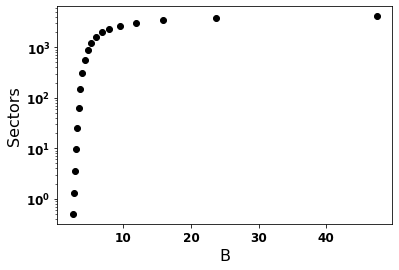

In [338]:
fspace = np.linspace(-.4,0,20)
m = .05
a =  1
tau = 1
r0=.01
K = 1000
H0=.5
for f in fspace:
    v = velocity(r0,m,f)
    Ne =1/Lambda_theory_Allee(f, K , -100, 40, .01,r0,m)

    Ds = m*a**2/2
    Dg= a / ( Ne*tau)
    sig = v*Ds/(R0*Dg**2)
    print(Nr(v,Dg,H0,20,Ds))
    
    plt.scatter(-1/f,1/Dg , c='k')
    
plt.yscale('log')
plt.ylabel('Sectors',fontsize=16)
plt.xlabel('B',fontsize=16)

In [93]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import glob


from sklearn import linear_model

def create_vel_avg(N, B_pulled, B_pushed):
    path = './data/stochastic_simulations/velocity/N'+N+'/'
    file_name = path+'/velocity_N'+N+'_gf0.01_migr0.25_B'+B_pulled+'_run0_demes300.txt'
    vel_pulled_avg = np.loadtxt(file_name, delimiter=',')
    file_name = path+'/velocity_N'+N+'_gf0.01_migr0.25_B'+B_pushed+'_run0_demes300.txt'
    vel_pushed_avg = np.loadtxt(file_name, delimiter=',')

    counter = 1
    for file_name in glob.glob(path+'/velocity_N'+N+'_gf0.01_migr0.25_B'+B_pulled+'_*.txt'):
        vel_arr = np.loadtxt(file_name, delimiter=',')
        vel_pulled_avg += vel_arr
        counter += 1
    vel_pulled_avg /= counter
    
    counter = 1
    for file_name in glob.glob(path+'velocity_N'+N+'_gf0.01_migr0.25_B'+B_pushed+'_*.txt'):
        vel_arr = np.loadtxt(file_name, delimiter=',')
        vel_pushed_avg += vel_arr
        counter += 1
    vel_pushed_avg /= counter

    np.save(path+'pulled_avg', vel_pulled_avg)
    np.save(path+'pushed_avg', vel_pushed_avg)


def Fig3_fluctuations(n_lines):
    font = {'family' : 'sans-serif', 'serif' : 'Helvetica Neue', 'weight' : 'bold', 'size' : 10}
    matplotlib.rc('font', **font)

    B_pulled='2'
    B_pushed='5'
    axis_size=10
    label_size=12
    #create_vel_avg('1000000', B_pulled, B_pushed)
    vel_pulled_avg = np.load('data/stochastic_simulations/velocity/pulled_avg.npy')
    vel_pushed_avg = np.load('data/stochastic_simulations/velocity/pushed_avg.npy')

    fig = plt.figure(figsize=(cm2inch(11.4), cm2inch(11.4)), dpi=500)

    ax3 = fig.add_subplot(221)
    ax3.set_title('pulled', fontsize=label_size, fontweight='bold', color='lightsalmon')
    ax3.text(-20000, 22, 'A', fontsize=label_size, fontweight='bold')
    ax3.set_ylabel('wandering, $\mathbf{X_f - vt}$', fontsize=axis_size, fontweight='bold')
    ax3.set_xlim(0, 50000)
    ax3.set_ylim(-20, 20)
    ax3.set_xticks([0, 25000, 50000])
    ax3.set_xticklabels([0, 25, 50])
    ax3.set_yticks([-20, 0, 20])

    ax4 = fig.add_subplot(222)
    ax4.set_title('pushed', fontsize=label_size, fontweight='bold', color='lightskyblue')
    ax4.text(-15000, 22, 'B', fontsize=label_size, fontweight='bold')
    ax4.set_xlim(0, 50000)
    ax4.set_ylim(-20, 20)
    ax4.set_xticks([0, 25000, 50000])
    ax4.set_xticklabels([0, 25, 50])
    ax4.set_yticks([-20, 0, 20])

    ax1 = fig.add_subplot(223)
    ax1.text(-7000, 1.10, 'C', fontsize=label_size, fontweight='bold')
    ax1.set_xlabel('time, t\n'+'$\mathbf{\\times}$ 1000', fontsize=axis_size, fontweight='bold')
    ax1.set_ylabel('fraction, f', fontsize=axis_size, fontweight='bold')
    ax1.set_xlim(0, 20000)
    ax1.set_ylim(0, 1)
    ax1.set_xticks([0, 10000, 20000])
    ax1.set_xticklabels([0, 10, 20])
    ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax1.set_yticklabels(['0', '0.25', '0.5', '0.75', '1'])

    ax2 = fig.add_subplot(224)
    ax2.text(-5000, 1.10, 'D', fontsize=label_size, fontweight='bold')
    ax2.set_xlabel('time, t\n'+'$\mathbf{\\times}$ 1000', fontsize=axis_size, fontweight='bold')
    ax2.set_xlim(0, 20000)
    ax2.set_ylim(0, 1)
    ax2.set_xticks([0, 10000, 20000])
    ax2.set_xticklabels([0, 10, 20])
    ax2.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax2.set_yticklabels(['0', '0.25', '0.5', '0.75', '1'])


    hetero_path = './data/stochastic_simulations/hetero/'
    velocity_path = './data/stochastic_simulations/velocity/'

    het_pulled = []
    het_pushed = []
    vel_pulled = []
    vel_pushed = []

    for run in range(50, 50+n_lines):
        file_name = hetero_path+'hetero_N1000000_gf0.01_migr0.25_B'+B_pulled+'_run'+str(run)+'_demes300.txt'
        het_arr = np.loadtxt(file_name, delimiter=',')
        t_arr = het_arr.T[0]
        f_arr = het_arr.T[2]
        f_end = f_arr[len(f_arr)/5]
        het_pulled.append(f_end)
        ax1.plot(t_arr, f_arr, c='r', lw=0.1)

        file_name = hetero_path+'hetero_N1000000_gf0.01_migr0.25_B'+B_pushed+'_run'+str(run)+'_demes300.txt'
        het_arr = np.loadtxt(file_name, delimiter=',')
        t_arr = het_arr.T[0]
        f_arr = het_arr.T[2]
        f_end = f_arr[len(f_arr)/5]
        het_pushed.append(f_end)
        ax2.plot(t_arr, f_arr, c='b', lw=0.1)

        file_name = velocity_path+'velocity_N1000000_gf0.01_migr0.25_B'+B_pulled+'_run'+str(run)+'_demes300.txt'
        vel_arr = np.loadtxt(file_name, delimiter=',')
        t_arr = vel_arr.T[0]
        X_arr = vel_arr.T[1] - vel_pulled_avg.T[1]
        x_end = X_arr[len(X_arr)/2]
        vel_pulled.append(x_end)
        ax3.plot(t_arr, X_arr, c='r', lw=0.1)


        file_name = velocity_path+'velocity_N1000000_gf0.01_migr0.25_B'+B_pushed+'_run'+str(run)+'_demes300.txt'
        vel_arr = np.loadtxt(file_name, delimiter=',')
        t_arr = vel_arr.T[0]
        X_arr = vel_arr.T[1] - vel_pushed_avg.T[1]
        x_end = X_arr[len(X_arr)/2]
        vel_pushed.append(x_end)
        ax4.plot(t_arr, X_arr, c='b', lw=0.1)


    plt.tight_layout(pad=1.8, w_pad=0.2, h_pad=2.0)
    plt.savefig('plots/Fig3_fluctuations.pdf')

def make_var_plot(ax, label):
    ax.set_xlabel('time, t', fontweight='bold', fontsize=8)
    ax.set_ylabel('front wandering, $\mathbf{\\langle (X_f - vt)^2\\rangle}$', fontweight='bold', fontsize=8)
    ax.text(-3000, 115, label, fontweight='bold', fontsize=12)
    ax.text(6000, 50, '$\\langle \Delta X_{\mathrm{f}}^2\\rangle = 2D_{\mathrm{f}}t$', fontsize=9, color='k')
    ax.set_xticks([0, 8000, 16000])
    ax.set_yticks([0, 25, 50, 75, 100])

    var_array = np.load('data/stochastic_simulations/var_comparison_data.npy')
    B_arr = np.load('data/stochastic_simulations/B_wandering_comparison.npy')

    pulled_B = B_arr[np.where(B_arr <= 2.0)]
    pushed_B = B_arr[np.where(B_arr > 2.0)]

    colors={}
    labels={}
    for elem in pulled_B:
        colors[elem] = 'r'
        labels[elem] = 'pulled'
    for elem in pushed_B:
        colors[elem] = 'b'
        labels[elem] = 'pushed'

    number_of_points = 20
    reduced_var_indices = (800/number_of_points)*np.arange(number_of_points)

    max_time = 1
    max_var = 1
    for i, B in enumerate(B_arr):
        time = var_array[i].T[0][10:]
        var = var_array[i].T[2][10:]

        t_plot = [time[i] for i in reduced_var_indices]
        var_plot = [var[i] for i in reduced_var_indices]
        max_time = max(max_time, max(t_plot))
        max_var = max(max_var, max(var_plot))

        #Calculate front wandering diffusion constant
        coeffs, r2 = linear_reg(time, var)
        Diff_const = coeffs[0]/2.
        fit = np.poly1d(coeffs)
        t_fit = [time[50], 1.1*t_plot[-1]] #choose range for plotting fit
        est = fit(t_fit)

        #Plot results
        ax.scatter(t_plot, var_plot, s=20, edgecolor=colors[B], facecolor='none', label=labels[B], lw=1)
        ax.plot(t_fit, est, c=colors[B], lw=1)

    ax.set_xlim([0, 1.1*max_time])
    ax.set_ylim([0,110])

    handles,labels = ax.get_legend_handles_labels()
    handles = [handles[1], handles[0]]
    labels = [labels[1], labels[0]]
    legend_properties={'weight':'normal', 'size':6}
    ax.legend(handles, labels, loc='best', prop=legend_properties, scatterpoints=1)


def make_D_scaling_plot(ax, label):
    diff_data = np.load('data/stochastic_simulations/D_comparison_data.npy')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('population size, N', fontweight='bold', fontsize=8)
    ax.set_ylabel('diffusion constant, $\mathbf{D_{\mathrm{f}}}$', fontweight='bold', fontsize=8)
    ax.text(1E2, 1.5E-1, label, fontweight='bold', fontsize=12)
    ax.text(2E5, 2E-5, '$D_{\mathrm{f}} \sim N^{\\alpha_{\mathrm{D}}}$', fontsize=9, color='k')
    ax.set_yticks([1E-2, 1E-4, 1E-6])
    ax.set_xlim([4E2, 1E7])
    ax.set_ylim([1E-7, 1E-1])

    for i, elem in enumerate(diff_data):
        B = elem[0][0]
        N_arr = elem[1]
        D_arr = elem[2]

        x_theory = list(N_arr)
        x_theory.append(0.2*min(N_arr))
        x_theory.append(5*max(N_arr))
        x_theory = np.array(sorted(x_theory))

        #fit theory
        regr = linear_model.LinearRegression()
        X = np.array(np.log(N_arr)**(-3)).reshape(len(N_arr), 1)
        Y = D_arr.reshape(len(D_arr), 1)
        regr.fit(X, Y)
        const = D_arr[np.where(N_arr==500000)]*np.log(N_arr[np.where(N_arr==500000)])**3
        Df_theory = const/(np.log(x_theory)**3)

        coeffs, res = linear_reg(np.log(N_arr), np.log(D_arr))
        fit = np.poly1d(coeffs)
        N_fit = [0.1*min(N_arr), 5*max(N_arr)]
        est = np.exp(fit(np.log(N_fit)))

        if B > 4.0:
            clr='b'
            ax.plot(N_fit, est, c=clr, lw=1, ls=':')
            ax.scatter(N_arr, D_arr, s=30, edgecolor=clr, facecolor='none', lw=1)
        else:
            clr='r'
            ax.plot(x_theory, Df_theory, lw=1, ls='-', c=clr, label='theory, $\ln^{-3}{N}$')
            ax.plot(N_fit, est, lw=1, ls=':', c=clr, label='power law fit')
            ax.scatter(N_arr, D_arr, s=30, edgecolor=clr, facecolor='none', lw=1, label='simulations')

    legend_properties={'weight':'normal', 'size':6}
    ax.legend(loc='lower left', prop=legend_properties, scatterpoints=1)

def make_D_phase_plot(ax, label, axis_fontsize, title_fontsize, markings_fontsize):
    x_min = -0.2
    x_max = 10.3
    y_min = -1.05
    y_max = 0.
    y_arr = np.arange(-1.0, 0., 0.001)
    x_weak = 4.0*np.ones(len(y_arr))
    x_pulled_2 = 2.0*np.ones(len(y_arr))
    x_metastable = np.zeros(len(y_arr))

    x_one = np.arange(x_min, x_max, 0.001)
    y_one = -np.ones(len(x_one))

    #For plotting horizontal lines
    x_full = np.arange(x_min, x_max, 0.001)
    x_pushed = np.arange(2.0, x_max, 0.001)
    x_pulled = np.arange(x_min, 2.0, 0.001)
    x_sublinear = np.arange(x_min, 4.0, 0.001)
    x_linear = np.arange(4.0, x_max, 0.001)

    x_weak_pushed = np.arange(2.0, x_max, 0.001)
    x_strong_pushed = np.arange(0.0, 0.3, 0.001)
    ones_full = np.ones(len(x_full))#horizontal line

    ax.set_xlabel('cooperativity, B', fontsize=axis_fontsize, fontweight='bold')
    ax.set_ylabel('diffusion exponent, $\mathbf{\\alpha_{\mathrm{D}}}$', fontsize=axis_fontsize, fontweight='bold')
    ax.text(-2.5, 0.05, label, fontweight='bold', fontsize=12)

    ax.set_xticks([0, 2, 4, 6, 8, 10])
    ax.set_yticks([0.0, -0.25, -0.5, -0.75, -1.0])
    #ax.set_yticks([0.0, -0.25, -0.5, -0.75, -1.0], ['0', '-0.25', '-0.5', '-0.75', '-1'])
    ax.set_yticklabels(['0', '-0.25', '-0.5', '-0.75', '-1'])
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])

    ax.fill_between(x_pushed, y_min, y_max, facecolor='lightskyblue', alpha=0.5)
    ax.fill_between(x_pulled, y_min, y_max, facecolor='lightsalmon', alpha=0.5)
    ax.plot(x_one, y_one, ls='--', c='k')
    ax.plot(x_full, ones_full, '--', c='k', lw=2)

    ax.scatter(D_array.T[0], D_array.T[1], s=30, lw=2, edgecolor='none', marker='+', c='k')

    ax.text(-0.2, 0.03, 'pulled', fontsize=title_fontsize, fontweight='bold', color='lightsalmon')
    ax.text(4.5, 0.03, 'pushed', fontsize=title_fontsize, fontweight='bold', color='lightskyblue')
    ax.text(2.5, -0.2, 'semi-\n'+'pushed', fontsize=markings_fontsize, fontweight='bold', color='k')
    ax.text(7.0, -0.2, 'fully-\n'+'pushed', fontsize=markings_fontsize, fontweight='bold', color='k')


def Fig4_Df_summary():
    font = {'family' : 'sans-serif', 'serif' : 'Helvetica Neue', 'weight' : 'bold', 'size' : 8}
    matplotlib.rc('font', **font)

    fig = plt.figure(figsize=(cm2inch(17.8), cm2inch(5.9)), dpi=100)
    ax = fig.add_subplot(131)
    make_var_plot(ax, 'A')
    ax = fig.add_subplot(132)
    make_D_scaling_plot(ax, 'B')
    ax = fig.add_subplot(133)
    make_D_phase_plot(ax, 'C', 8, 8, 8)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig('plots/Fig4_diffusion.pdf')



def fit_heterozygosity(x_het, het, surv):
    X_INIT = min(min(range(len(het)), key=lambda i:abs(het[i] - 0.1)), 1000) #find initial fitting point
    X_FIN = 0
    while (surv[X_FIN] > 0.05 and X_FIN < len(het) - 1):
        X_FIN += 1 #find final fitting point

    if (X_FIN - X_INIT <= 400):
        X_INIT = max(0, X_FIN - 400)

    X_THIRD = int((X_FIN - X_INIT)/3)
    xh = x_het[X_INIT:X_FIN]
    het_fit = het[X_INIT:X_FIN]
    coeffs, r_sq = linear_reg(xh, np.log(het_fit))#Do fit
    return xh, het_fit, coeffs, r_sq


def make_het_comparison(het_data, ax, label, axis_fontsize):
    B_comparison = np.load('data/stochastic_simulations/B_neff_comparison.npy')

    ax.set_yscale('log')
    ax.ticklabel_format(style='sci', scilimit=(-2,2), axis='x')
    ax.set_xlabel('time, t', fontweight='bold', fontsize=axis_fontsize)
    ax.set_ylabel('heterozygosity, H', fontweight='bold', fontsize=axis_fontsize)
    ax.text(-2000, 1.5E1, label, fontweight='bold', fontsize=12)
    ax.text(7000, 5E-2, '$H \sim e^{-\Lambda t}$', fontsize=10, color='k')
    ax.set_xticks([0, 4000, 8000])
    ax.set_yticks([1E-4, 1E-2, 1])
    ax.set_ylim([1E-4, 1E1])

    number_of_points = 20
    reduced_het_indices = (1000/number_of_points)*np.arange(number_of_points)

    for elem in het_data:
        deme = elem[0][0]
        B = elem[0][1]
        x_het = elem[1].T[0]
        het = elem[1].T[1]
        surv = elem[1].T[2]

        x_plot = [x_het[i] for i in reduced_het_indices]
        het_plot = [het[i] for i in reduced_het_indices]
                
        xh, het_fit, coeffs, r_sq = fit_heterozygosity(x_het, het, surv)
        fit = np.poly1d(coeffs)
        x_fit = [x_het[50], 1.1*x_het[-1]] #choose range for plotting fit
        est = np.exp(fit(x_fit))

        #Plot results
        if B > 4.0:
            clr = 'b'
            lbl = 'pushed'
        else:
            clr = 'r'
            lbl = 'pulled'
        ax.scatter(x_plot, het_plot, s=20, edgecolor=clr, facecolor='none', lw=1, label=lbl)
        ax.plot(x_fit, est, c=clr, lw=1)
    ax.set_xlim([0, 12000])

    legend_properties={'weight':'normal', 'size':6}
    ax.legend(loc='best', prop=legend_properties, scatterpoints=1)


def make_neff_comparison(neff_data, ax, label, axis_fontsize):
    B_comparison = np.load('data/stochastic_simulations/B_neff_comparison.npy')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('population size, N', fontweight='bold', fontsize=axis_fontsize)
    ax.set_ylabel('rate of diversity loss, $\mathbf{\Lambda}$', fontweight='bold', fontsize=axis_fontsize)
    ax.text(2E2, 8E-3, label, fontweight='bold', fontsize=12)
    ax.text(2E5, 8E-6, '$\Lambda \sim N^{\\alpha_{\mathrm{H}}}$', fontsize=10, color='k')
    ax.set_yticks([1E-3, 1E-5, 1E-7])
    ax.set_ylim([1E-7, 5E-3])

    for i, elem in enumerate(neff_data):
        B = B_comparison[i]
        N_arr = elem[0]
        kappa_arr = elem[1]

        x_BSC = list(N_arr)
        x_BSC.append(0.2*min(N_arr))
        x_BSC.append(5*max(N_arr))
        x_BSC = np.array(sorted(x_BSC))

        #fit theory
        regr = linear_model.LinearRegression()
        X = np.array(np.log(N_arr)**(-3)).reshape(len(N_arr), 1)
        Y = kappa_arr.reshape(len(kappa_arr), 1)
        regr.fit(X, Y)
        const = regr.coef_[0][0]
        const = kappa_arr[np.where(N_arr==500000)]*np.log(N_arr[np.where(N_arr==500000)])**3
        kappa_BSC = const/(np.log(x_BSC)**3)


        if len(N_arr) != 0 and len(kappa_arr) != 0:
            coeffs, res = linear_reg(np.log(N_arr), np.log(kappa_arr))
            fit = np.poly1d(coeffs)
            N_fit = [0.2*min(N_arr), 5*max(N_arr)]
            est = np.exp(fit(np.log(N_fit)))

            if B > 4.0:
                clr='b'
                ax.plot(N_fit, est, c=clr, lw=1, ls=':')
                ax.scatter(N_arr, kappa_arr, s=30, edgecolor=clr, facecolor='none', lw=1)
            else:
                clr='r'
                ax.plot(x_BSC, kappa_BSC, lw=1, ls='-', c=clr, label='theory, $\ln^{-3}{N}$')
                ax.plot(N_fit, est, lw=1, ls=':', c=clr, label='power law fit')
                ax.scatter(N_arr, kappa_arr, s=30, edgecolor=clr, facecolor='none', lw=1, label='simulations')

    legend_properties={'weight':'normal', 'size':6}
    ax.legend(loc='lower left', prop=legend_properties, scatterpoints=1)

def make_Lambda_phase_plot(ax, label, axis_fontsize, title_fontsize, markings_fontsize):
    x_min = -0.2
    x_max = 10.3
    y_min = -1.05
    y_max = 0.
    y_arr = np.arange(-1.0, 0., 0.001)
    x_weak = 4.0*np.ones(len(y_arr))
    x_pulled_2 = 2.0*np.ones(len(y_arr))
    x_metastable = np.zeros(len(y_arr))

    x_one = np.arange(x_min, x_max, 0.001)
    y_one = -np.ones(len(x_one))

    #For plotting horizontal lines
    x_full = np.arange(x_min, x_max, 0.001)
    x_pushed = np.arange(2.0, x_max, 0.001)
    x_pulled = np.arange(x_min, 2.0, 0.001)
    x_sublinear = np.arange(x_min, 4.0, 0.001)
    x_linear = np.arange(4.0, x_max, 0.001)

    x_weak_pushed = np.arange(2.0, x_max, 0.001)
    x_strong_pushed = np.arange(0.0, 0.3, 0.001)
    ones_full = np.ones(len(x_full))#horizontal line

    ax.set_xlabel('cooperativity, B', fontsize=axis_fontsize, fontweight='bold')
    ax.set_ylabel('diversity exponent, $\mathbf{\\alpha_{\mathrm{H}}}$', fontsize=axis_fontsize, fontweight='bold')
    ax.text(-2.5, 0.05, label, fontweight='bold', fontsize=12)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])

    #Plot extras
    ax.fill_between(x_pushed, y_min, y_max, facecolor='lightskyblue', alpha=0.5)
    ax.fill_between(x_pulled, y_min, y_max, facecolor='lightsalmon', alpha=0.5)
    ax.plot(x_one, y_one, ls='--', c='k')
    ax.plot(x_full, ones_full, '--', c='k', lw=2)

    ax.scatter(gamma_list_r.T[0], gamma_list_r.T[1], s=30, marker='s', lw=2, edgecolor='k', facecolor='none')

    ax.text(-0.2, 0.03, 'pulled', fontsize=title_fontsize, fontweight='bold', color='lightsalmon')
    ax.text(4.5, 0.03, 'pushed', fontsize=title_fontsize, fontweight='bold', color='lightskyblue')
    ax.text(2.5, -0.2, 'semi-\n'+'pushed', fontsize=markings_fontsize, fontweight='bold', color='k')
    ax.text(7.0, -0.2, 'fully-\n'+'pushed', fontsize=markings_fontsize, fontweight='bold', color='k')
    
def Fig5_Lambda_summary(het_data, neff_data):
    font = {'family' : 'sans-serif', 'serif' : 'Helvetica Neue', 'weight' : 'bold', 'size' : 6}
    matplotlib.rc('font', **font)

    fig = plt.figure(figsize=(cm2inch(17.8), cm2inch(5.9)), dpi=100)
    ax = fig.add_subplot(131)
    make_het_comparison(het_data, ax, 'A', 8)
    ax = fig.add_subplot(132)
    make_neff_comparison(neff_data, ax, 'B', 8)
    ax = fig.add_subplot(133)
    make_Lambda_phase_plot(ax, 'C', 8, 8, 8)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig('plots/Fig5_diversity.pdf')

def Fig6_collapse():
    font = {'family' : 'sans-serif', 'serif' : 'Helvetica Neue', 'weight' : 'bold', 'size' : 12}
    matplotlib.rc('font', **font)

    coop_arr = np.load('data/diversity_exponents_universal_coop.npy')
    allee_arr = np.load('data/diversity_exponents_universal_Allee.npy')
    quartic_arr = np.load('data/diversity_exponents_universal_quartic.npy')
    theory_arr = np.load('data/diversity_exponents_universal_theory.npy')
    D_coop = np.load('data/D_array.npy')
    D_allee = np.load('data/D_array_allee.npy')
    D_quartic = np.load('data/D_array_quartic.npy')

    x_coop = coop_arr.T[2]/coop_arr.T[1]
    y_coop = coop_arr.T[3]
    x_allee = allee_arr.T[2]/allee_arr.T[1]
    y_allee = allee_arr.T[3]
    x_quartic = quartic_arr.T[2]/quartic_arr.T[1]
    y_quartic = quartic_arr.T[3]


    new_D_coop = []
    for i, elem_D in enumerate(D_coop):
        for j, elem_x in enumerate(coop_arr):
            if (elem_D[0] == elem_x[4]):
                new_D_coop.append([elem_D[0], elem_x[2]/elem_x[1], elem_D[1]])
    new_D_coop = np.array(new_D_coop)

    new_D_allee = []
    for i, elem_D in enumerate(D_allee):
        for j, elem_x in enumerate(allee_arr):
            if (elem_D[0] == elem_x[4]):
                new_D_allee.append([elem_D[0], elem_x[2]/elem_x[1], elem_D[1]])
    new_D_allee = np.array(new_D_allee)

    new_D_quartic = []
    for i, elem_D in enumerate(D_quartic):
        for j, elem_x in enumerate(quartic_arr):
            if (elem_D[0] == elem_x[4]):
                new_D_quartic.append([elem_D[0], elem_x[2]/elem_x[1], elem_D[1]])
    new_D_quartic = np.array(new_D_quartic)


    y_min = -1.05
    y_max = 0.

    y_transition = np.arange(y_min, y_max, 0.001)
    x_transition = 1.061*np.ones(len(y_transition))

    B_theory = np.arange(2.0, 4.0, 0.001)
    vvf_pushed = np.arange(1.06, 1.4, 0.001)
    [vvf_theory, exp_theory] = theory_arr 

    fig = plt.figure(figsize=(cm2inch(11.4),cm2inch(9.4)))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('expansion velocity, $\mathbf{v/v_F}$', fontweight='bold', fontsize=12)
    ax.set_ylabel('exponents, $\mathbf{\\alpha_H}$, $\mathbf{\\alpha_D}$', fontweight='bold', fontsize=12)
    ax.set_xlim(0.99, 1.4)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks([1.0, 1.1, 1.2, 1.3, 1.4])
    ax.set_yticks([0.0, -0.2, -0.4, -0.6, -0.8, -1.0])
    ax.plot(vvf_theory, exp_theory, c='r', lw=4, label='theory', zorder=1)
    ax.plot(vvf_pushed, -np.ones(len(vvf_pushed)), c='r', lw=4, zorder=1)
    p1=ax.scatter(x_coop, y_coop, s=80, edgecolor='k', facecolor='none', marker='s', zorder=2)
    p2=ax.scatter(x_allee, y_allee, s=80, edgecolor='k', facecolor='none', marker='^', lw=2, zorder=2)
    p5=ax.scatter(x_quartic, y_quartic, s=80, edgecolor='k', facecolor='none', marker='v', lw=2, zorder=2)
    p3=ax.scatter(new_D_coop.T[1], new_D_coop.T[2], s=80, edgecolor='none', facecolor='k', marker='+', lw=2, zorder=2)
    p4=ax.scatter(new_D_allee.T[1], new_D_allee.T[2], s=80, edgecolor='none', facecolor='k', marker='x', lw=2, zorder=2)
    p5=ax.scatter(new_D_quartic.T[1], new_D_quartic.T[2], s=150, edgecolor='none', facecolor='k', marker='*', lw=2, zorder=2)

    #make legend
    ax.add_patch(patches.Rectangle((1.20, -0.28), 0.190, 0.25, fill=False))
    ax.scatter(1.22, -0.08, s=80, edgecolor='k', facecolor='none', marker='s', lw=2)
    ax.scatter(1.26, -0.08, s=80, edgecolor='k', facecolor='none', marker='^', lw=2)
    ax.scatter(1.30, -0.08, s=80, edgecolor='k', facecolor='none', marker='v', lw=2)
    ax.scatter(1.22, -0.15, s=80, edgecolor='none', facecolor='k', marker='+', lw=2)
    ax.scatter(1.26, -0.15, s=80, edgecolor='none', facecolor='k', marker='x', lw=2)
    ax.scatter(1.30, -0.15, s=150, edgecolor='none', facecolor='k', marker='*', lw=2)
    ax.plot([1.22, 1.275], [-0.22, -0.22], c='r', lw=4)
    ax.text(1.33, -0.10, '$\mathbf{\\alpha_H}$', fontsize=16, fontweight='bold')
    ax.text(1.33, -0.17, '$\mathbf{\\alpha_D}$', fontsize=16, fontweight='bold')
    ax.text(1.305, -0.23, 'theory', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig('plots/Fig6_collapse.pdf')



    


In [89]:
make_Lambda_phase_plot

<function __main__.make_Lambda_phase_plot(ax, label, axis_fontsize, title_fontsize, markings_fontsize)>

In [149]:
Nr(v,Dg,H0,R,)

<function __main__.<lambda>(v, Dg, H0, R, V, Ds)>

In [94]:
    font = {'family' : 'sans-serif', 'serif' : 'Helvetica Neue', 'weight' : 'bold', 'size' : 12}
    matplotlib.rc('font', **font)

    gamma_list_r = np.load('data/gamma_list_r.npy')
    gamma_list_v = np.load('data/gamma_list_v.npy')
    lambda_comparison_arr = np.load('data/neff_comparison_data.npy')
    het_data = np.load('data/hetero_plot_data.npy')
    D_array = np.load('data/D_array.npy')


    Fig1_growth(labels_flag=1, label_size=8)
    Fig2_fixation(label_size=9, markings_size=9)
    Fig3_fluctuations(50)
    Fig4_Df_summary()
    Fig5_Lambda_summary(het_data, lambda_comparison_arr)
    Fig6_collapse()

    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/gamma_list_r.npy'

In [95]:
Fig5_Lambda_summary(het_data, lambda_comparison_arr)

NameError: name 'het_data' is not defined

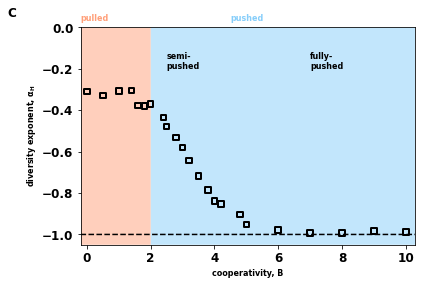

In [105]:
fig,ax = plt.subplots()

gamma_list_r = np.load('gamma_list_r.npy')
make_Lambda_phase_plot(ax, 'C', 8, 8, 8)